In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import mpl_finance as mpf
import numpy as np
from scipy import integrate
from scipy.stats import t

In [2]:
def heikin_ashi(df1):
    
    df1.reset_index(inplace=True)
    
    df1['HA close']=(df1['Open']+df1['Close']+df1['High']+df1['Low'])/4

    #initialize heikin ashi open
    df1['HA open']=float(0)
    df1['HA open'][0]=df1['Open'][0]

    for n in range(1,len(df1)):
        df1.at[n,'HA open']=(df1['HA open'][n-1]+df1['HA close'][n-1])/2

    temp=pd.concat([df1['HA open'],df1['HA close'],df1['Low'],df1['High']],axis=1)
    df1['HA high']=temp.apply(max,axis=1)
    df1['HA low']=temp.apply(min,axis=1)


    del df1['Adj Close']
    del df1['Volume']
    
    return df1

In [3]:
def signal_generation(df,method,stls):
        
    df1=method(df)
    
    df1['signals']=0

    #i use cumulated sum to check how many positions i have longed
    #i would ignore the exit signal prior to no long positions in the portfolio
    #i also keep tracking how many long positions i have got
    #long signals cannot exceed the stop loss limit
    df1['cumsum']=0

    for n in range(1,len(df1)):
        
        if (df1['HA open'][n]>df1['HA close'][n] and df1['HA open'][n]==df1['HA high'][n] and
            np.abs(df1['HA open'][n]-df1['HA close'][n])>np.abs(df1['HA open'][n-1]-df1['HA close'][n-1]) and
            df1['HA open'][n-1]>df1['HA close'][n-1]):
            
            df1.at[n,'signals']=1
            df1['cumsum']=df1['signals'].cumsum()


            #stop longing positions
            if df1['cumsum'][n]>stls:
                df1.at[n,'signals']=0
        

        elif (df1['HA open'][n]<df1['HA close'][n] and df1['HA open'][n]==df1['HA low'][n] and 
        df1['HA open'][n-1]<df1['HA close'][n-1]):
            
            df1.at[n,'signals']=-1
            df1['cumsum']=df1['signals'].cumsum()
        

            #if long positions i hold are more than one
            #its time to clear all my positions
            #if there are no long positions in my portfolio
            #ignore the exit signal
            if df1['cumsum'][n]>0:
                df1.at[n,'signals']=-1*(df1['cumsum'][n-1])

            if df1['cumsum'][n]<0:
                df1.at[n,'signals']=0
                
    return df1

In [4]:
def plot(df1,ticker):
    
    
    df1.set_index(df1['Date'],inplace=True)
    
    #first plot is Heikin-Ashi candlestick
    #use candlestick function and set Heikin-Ashi O,C,H,L
    ax1=plt.subplot2grid((200,1), (0,0), rowspan=120,ylabel='HA price')
    mpf.candlestick2_ochl(ax1, df1['HA open'], df1['HA close'], df1['HA high'], df1['HA low'], width=1, colorup='g', colordown='r')
    plt.grid(True)
    plt.xticks([])
    plt.title('Heikin-Ashi')


    #the second plot is the actual price with long/short positions as up/down arrows
    ax2=plt.subplot2grid((200,1), (120,0), rowspan=80,ylabel='price',xlabel='')
    df1['Close'].plot(ax=ax2,label=ticker)

    #long/short positions are attached to the real close price of the stock
    #set the line width to zero
    #thats why we only observe markers
    ax2.plot(df1.loc[df1['signals']==1].index,df1['Close'][df1['signals']==1],marker='^',lw=0,c='g',label='long')
    ax2.plot(df1.loc[df1['signals']<0].index,df1['Close'][df1['signals']<0],marker='v',lw=0,c='r',label='short')

    plt.grid(True)
    plt.legend(loc='best')
    plt.show()

In [5]:
def portfolio(df1):
    
    #initial capital to calculate the actual pnl
    capital0=10000

    #shares to buy of every position
    positions=100
    
    #cumsum column is created to check the holding of the position
    df1['cumsum']=df1['signals'].cumsum()

    portfolio=pd.DataFrame()
    portfolio['holdings']=df1['cumsum']*df1['Close']*positions
    portfolio['cash']=capital0-(df1['signals']*df1['Close']*positions).cumsum()
    portfolio['total asset']=portfolio['holdings']+portfolio['cash']
    portfolio['return']=portfolio['total asset'].pct_change()
    portfolio['signals']=df1['signals']
    portfolio['date']=df1['Date']
    portfolio.set_index('date',inplace=True)

    return portfolio

In [6]:
def profit(portfolio):
    
    
    fig=plt.figure()
    bx=fig.add_subplot(111)
    
    portfolio['total asset'].plot(label='Total Asset')
    
    #long/short position markers related to the portfolio
    #the same mechanism as the previous one
    #replace close price with total asset value
    bx.plot(portfolio['signals'].loc[portfolio['signals']==1].index,portfolio['total asset'][portfolio['signals']==1],lw=0,marker='^',c='g',label='long')
    bx.plot(portfolio['signals'].loc[portfolio['signals']<0].index,portfolio['total asset'][portfolio['signals']<0],lw=0,marker='v',c='r',label='short')
    
    plt.legend(loc='best')
    plt.grid(True)
    plt.xlabel('Date')
    plt.ylabel('Asset Value')
    plt.title('Total Asset')
    plt.show()

In [7]:
def omega(risk_free,degree_of_freedom,maximum,minimum):

    y=integrate.quad(lambda g:1-t.cdf(g,degree_of_freedom),risk_free,maximum)
    x=integrate.quad(lambda g:t.cdf(g,degree_of_freedom),minimum,risk_free)

    z=(y[0])/(x[0])

    return z

In [8]:
def sortino(risk_free,degree_of_freedom,growth_rate,minimum):

    v=np.sqrt(np.abs(integrate.quad(lambda g:((risk_free-g)**2)*t.pdf(g,degree_of_freedom),risk_free,minimum)))
    s=(growth_rate-risk_free)/v[0]

    return s

In [9]:
def mdd(series):

    temp=0
    for i in range(1,len(series)):
        if temp>(series[i]/max(series[:i])-1):
            temp=(series[i]/max(series[:i])-1)

    return temp

In [10]:
def stats(portfolio,df1,stdate,eddate):

    stats=pd.DataFrame([0])

    #get the min and max of return
    maximum=np.max(portfolio['return'])
    minimum=np.min(portfolio['return'])
    capital0=10000

    #growth_rate denotes the average growth rate of portfolio 
    #i use geometric average instead of arithmetic average for percentage growth
    growth_rate=(float(portfolio['total asset'].iloc[-1]/capital0))**(1/len(df1))-1

    #calculating the standard deviation
    std=float(np.sqrt((((portfolio['return']-growth_rate)**2).sum())/len(df1)))

    #use S&P500 as benchmark
    benchmark=yf.download('^GSPC',start=stdate,end=eddate)

    #rb denotes the return of benchmark
    rb=float(benchmark['Close'].iloc[-1]/benchmark['Open'].iloc[0]-1)

    #rf denotes the average growth rate of benchmark 
    #i use geometric average instead of arithmetic average for percentage growth
    rf=(rb+1)**(1/len(df1))-1

    del benchmark

    #backtesting stats
    #CAGR stands for cumulated average growth rate
    stats['CAGR']=stats['portfolio return']=float(0)
    stats['CAGR'][0]=growth_rate
    stats['portfolio return'][0]=portfolio['total asset'].iloc[-1]/capital0-1
    stats['benchmark return']=rb
    stats['sharpe ratio']=(growth_rate-rf)/std
    stats['maximum drawdown']=mdd(portfolio['total asset'])

    #calmar ratio is sorta like sharpe ratio
    #the standard deviation is replaced by maximum drawdown
    #it is the measurement of return after worse scenario adjustment
    stats['calmar ratio']=growth_rate/stats['maximum drawdown']
    stats['omega ratio']=omega(rf,len(df1),maximum,minimum)
    stats['sortino ratio']=sortino(rf,len(df1),growth_rate,minimum)

    #note that i use stop loss limit to limit the numbers of longs
    #and when clearing positions, we clear all the positions at once
    #so every long is always one, and short could be no larger than the stop loss limit
    stats['numbers of longs']=df1['signals'].loc[df1['signals']==1].count()
    stats['numbers of shorts']=df1['signals'].loc[df1['signals']<0].count()
    stats['numbers of trades']=stats['numbers of shorts']+stats['numbers of longs']  

    #to get the total length of trades
    #given that cumsum indicates the holding of positions
    #we can get all the possible outcomes when cumsum doesnt equal zero
    #then we count how many non-zero positions there are
    #we get the estimation of total length of trades
    stats['total length of trades']=df1['signals'].loc[df1['cumsum']!=0].count()
    stats['average length of trades']=stats['total length of trades']/stats['numbers of trades']
    stats['profit per trade']=float(0)
    stats['profit per trade'].iloc[0]=(portfolio['total asset'].iloc[-1]-capital0)/stats['numbers of trades'].iloc[0]

    del stats[0]
    print(stats)

In [11]:
def main():
    
    #initializing

    #stop loss positions, the maximum long positions we can get
    #without certain constraints, you will long indefinites times as long as the market condition triggers the signal
    #in a whipsaw condition, it is suicidal
    stls=3
    ticker='NVDA'
    stdate='2015-04-01'
    eddate='2018-02-15'

    #slice is used for plotting
    #a three year dataset with 750 variables would be too much for a figure
    slicer=700


    #downloading data
    df=yf.download(ticker,start=stdate,end=eddate)

    df1=signal_generation(df,heikin_ashi,stls)

    new=df1[slicer:]
    plot(new,ticker)

    portfo=portfolio(new)
    profit(portfo)

    stats(portfo,df1,stdate,eddate)

    #note that this is the only py file with complete stats calculation

[*********************100%***********************]  1 of 1 downloaded


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


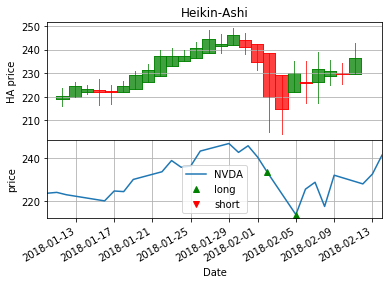

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


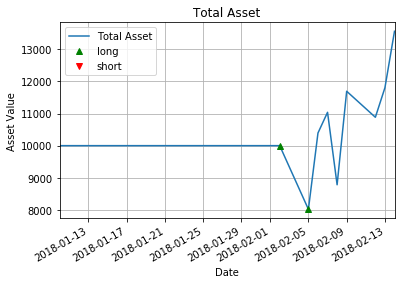

[*********************100%***********************]  1 of 1 downloaded
      CAGR  portfolio return  benchmark return  sharpe ratio  \
0  0.00042            0.3562           0.30518      0.002533   

   maximum drawdown  calmar ratio  omega ratio  sortino ratio  \
0         -0.204385     -0.002057      1.52946       0.001576   

   numbers of longs  numbers of shorts  numbers of trades  \
0                61                 32                 93   

   total length of trades  average length of trades  profit per trade  
0                     220                  2.365591         38.301075  


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [12]:
if __name__ == '__main__':
    main()